<a href="https://colab.research.google.com/github/avinashronanki/TOXICITY/blob/master/Copy_of_XLNet_toxic_comment_classification_challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install transformers

     |████████████████████████████████| 573kB 4.1MB/s 
     |████████████████████████████████| 3.7MB 61.4MB/s 
     |████████████████████████████████| 890kB 51.0MB/s 
     |████████████████████████████████| 1.0MB 30.0MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.41-cp36-none-any.whl size=893334 sha256=3ce1ad9814712e4c839feca3013b89875ca01597edbfd52e2c939999406d666e
  Stored in directory: /root/.cache/pip/wheels/22/5a/d4/b020a81249de7dc63758a34222feaa668dbe8ebfe9170cc9b1
Successfully built sacremoses


In [0]:
import os
import math

import torch
from torch.nn import BCEWithLogitsLoss
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AdamW, XLNetTokenizer, XLNetModel, XLNetLMHeadModel, XLNetConfig
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [0]:
print("GPU Available: {}".format(torch.cuda.is_available()))
n_gpu = torch.cuda.device_count()
print("Number of GPU Available: {}".format(n_gpu))
print("GPU: {}".format(torch.cuda.get_device_name(0)))

GPU Available: True
Number of GPU Available: 1
GPU: Tesla P100-PCIE-16GB


In [0]:
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Import Dataset

In [0]:
!unzip /content/test.csv.zip

Archive:  /content/test.csv.zip
  inflating: test.csv                


In [0]:
!unzip /content/train.csv.zip

Archive:  /content/train.csv.zip
  inflating: train.csv               


In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
train = pd.read_csv('/content/train.csv', index_col='id')
test = pd.read_csv('/content/test.csv', index_col='id')

In [0]:
train.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
id,,,,,,,
0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [0]:
test.head()

,comment_text
id,
00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
0000247867823ef7,== From RfC == \n\n The title is fine as it is...
00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
00017563c3f7919a,":If you have a look back at the source, the in..."
00017695ad8997eb,I don't anonymously edit articles at all.


In [0]:
train.shape

(159571, 7)

In [0]:
test.shape

(153164, 1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  


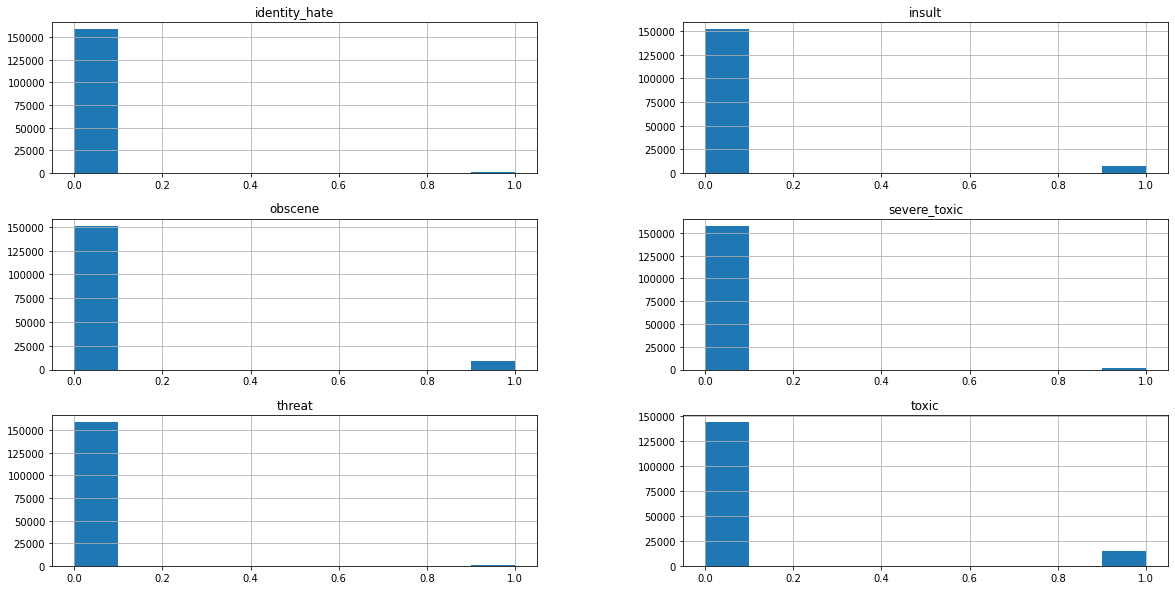

In [0]:
fig, ax = plt.subplots(figsize=(20, 10));
train[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]].hist(ax=ax);

In [0]:
train.isnull().mean()

comment_text     0.0
toxic            0.0
severe_toxic     0.0
obscene          0.0
threat           0.0
insult           0.0
identity_hate    0.0
dtype: float64

In [0]:
test.isnull().mean()

comment_text    0.0
dtype: float64

In [0]:
# get small sample of train to try
#train = train.sample(n=100)

## Preprocess Data

In [0]:
def plot_sentence_embeddings_length(text_list, tokenizer):
    tokenized_texts = list(map(lambda t: tokenizer.tokenize(t), text_list))
    tokenized_texts_len = list(map(lambda t: len(t), tokenized_texts))
    fig, ax = plt.subplots(figsize=(8, 5));
    ax.hist(tokenized_texts_len, bins=40);
    ax.set_xlabel("Length of Comment Embeddings");
    ax.set_ylabel("Number of Comments");
    return

In [0]:
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased', do_lower_case=True)

In [0]:
train_text_list = train["comment_text"].values
test_text_list = test["comment_text"].values

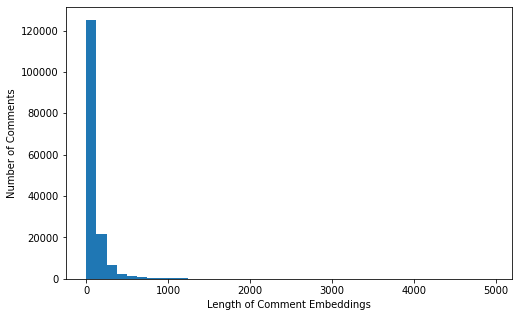

In [0]:
plot_sentence_embeddings_length(train_text_list, tokenizer)

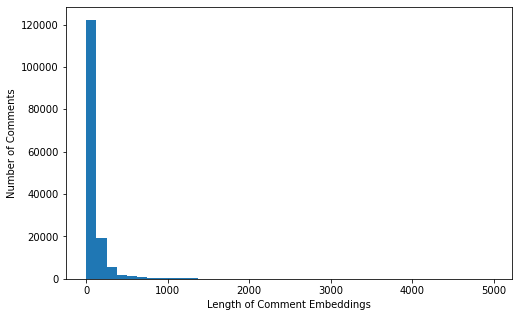

In [0]:
plot_sentence_embeddings_length(test_text_list, tokenizer)

In [0]:
def tokenize_inputs(text_list, tokenizer, num_embeddings=512):
    """
    Tokenizes the input text input into ids. Appends the appropriate special
    characters to the end of the text to denote end of sentence. Truncate or pad
    the appropriate sequence length.
    """
    # tokenize the text, then truncate sequence to the desired length minus 2 for
    # the 2 special characters
    tokenized_texts = list(map(lambda t: tokenizer.tokenize(t)[:num_embeddings-2], text_list))
    # convert tokenized text into numeric ids for the appropriate LM
    input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
    # append special token "<s>" and </s> to end of sentence
    input_ids = [tokenizer.build_inputs_with_special_tokens(x) for x in input_ids]
    # pad sequences
    input_ids = pad_sequences(input_ids, maxlen=num_embeddings, dtype="long", truncating="post", padding="post")
    return input_ids

def create_attn_masks(input_ids):
    """
    Create attention masks to tell model whether attention should be applied to
    the input id tokens. Do not want to perform attention on padding tokens.
    """
    # Create attention masks
    attention_masks = []

    # Create a mask of 1s for each token followed by 0s for padding
    for seq in input_ids:
        seq_mask = [float(i>0) for i in seq]
        attention_masks.append(seq_mask)
    return attention_masks

In [0]:
# create input id tokens
train_input_ids = tokenize_inputs(train_text_list, tokenizer, num_embeddings=250)
train_input_ids

array([[ 6267,   611,    18, ...,     0,     0,     0],
       [   17,    66,    26, ...,     0,     0,     0],
       [   43,   117,   326, ...,     0,     0,     0],
       ...,
       [16187,  5862,    17, ...,     0,     0,     0],
       [   21,    36,  1898, ...,     0,     0,     0],
       [   17,    12,    21, ...,     0,     0,     0]])

In [0]:
# create input id tokens
test_input_ids = tokenize_inputs(test_text_list, tokenizer, num_embeddings=250)
test_input_ids

array([[   17,  4333, 15683, ...,     0,     0,     0],
       [ 5847,  5383,    40, ...,     0,     0,     0],
       [   17,    12,  5847, ...,     0,     0,     0],
       ...,
       [   17,    12,  5847, ...,     0,     0,     0],
       [   17,    12,  5847, ...,     0,     0,     0],
       [   17,    12,    17, ...,     0,     0,     0]])

In [0]:
# create attention masks
train_attention_masks = create_attn_masks(train_input_ids)
train_attention_masks

In [0]:
# create attention masks
test_attention_masks = create_attn_masks(test_input_ids)
test_attention_masks

In [0]:
# add input ids and attention masks to the dataframe
train["features"] = train_input_ids.tolist()
train["masks"] = train_attention_masks

test["features"] = test_input_ids.tolist()
test["masks"] = test_attention_masks

In [0]:
train.head()

In [0]:
test.head()

## Train, Valid Split

In [0]:
# train valid split
train, valid = train_test_split(train, test_size=0.2, random_state=42)

In [0]:
X_train = train["features"].values.tolist()
X_valid = valid["features"].values.tolist()

train_masks = train["masks"].values.tolist()
valid_masks = valid["masks"].values.tolist()

label_cols = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
Y_train = train[label_cols].values.tolist()
Y_valid = valid[label_cols].values.tolist()

## Create Dataloaders

In [0]:
# Convert all of our input ids and attention masks into 
# torch tensors, the required datatype for our model

X_train = torch.tensor(X_train)
X_valid = torch.tensor(X_valid)

Y_train = torch.tensor(Y_train, dtype=torch.float32)
Y_valid = torch.tensor(Y_valid, dtype=torch.float32)

train_masks = torch.tensor(train_masks, dtype=torch.long)
valid_masks = torch.tensor(valid_masks, dtype=torch.long)

In [0]:
# Select a batch size for training
batch_size = 16

# Create an iterator of our data with torch DataLoader. This helps save on 
# memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(X_train, train_masks, Y_train)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data,\
                              sampler=train_sampler,\
                              batch_size=batch_size)

validation_data = TensorDataset(X_valid, valid_masks, Y_valid)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data,\
                                   sampler=validation_sampler,\
                                   batch_size=batch_size)

In [0]:
def train(model, num_epochs,\
          optimizer,\
          train_dataloader, valid_dataloader,\
          model_save_path,\
          train_loss_set=[], valid_loss_set = [],\
          lowest_eval_loss=None, start_epoch=0,\
          device="GPU"
          ):
  """
  Train the model and save the model with the lowest validation loss
  """

  model.to(device)

  # trange is a tqdm wrapper around the normal python range
  for i in trange(num_epochs, desc="Epoch"):
    # if continue training from saved model
    actual_epoch = start_epoch + i

    # Training

    # Set our model to training mode (as opposed to evaluation mode)
    model.train()

    # Tracking variables
    tr_loss = 0
    num_train_samples = 0

    # Train the data for one epoch
    for step, batch in enumerate(train_dataloader):
      # Add batch to GPU
      batch = tuple(t.to(device) for t in batch)
      # Unpack the inputs from our dataloader
      b_input_ids, b_input_mask, b_labels = batch
      # Clear out the gradients (by default they accumulate)
      optimizer.zero_grad()
      # Forward pass
      loss = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
      # store train loss
      tr_loss += loss.item()
      num_train_samples += b_labels.size(0)
      # Backward pass
      loss.backward()
      # Update parameters and take a step using the computed gradient
      optimizer.step()
      #scheduler.step()

    # Update tracking variables
    epoch_train_loss = tr_loss/num_train_samples
    train_loss_set.append(epoch_train_loss)

    print("Train loss: {}".format(epoch_train_loss))

    # Validation

    # Put model in evaluation mode to evaluate loss on the validation set
    model.eval()

    # Tracking variables 
    eval_loss = 0
    num_eval_samples = 0

    # Evaluate data for one epoch
    for batch in valid_dataloader:
      # Add batch to GPU
      batch = tuple(t.to(device) for t in batch)
      # Unpack the inputs from our dataloader
      b_input_ids, b_input_mask, b_labels = batch
      # Telling the model not to compute or store gradients,
      # saving memory and speeding up validation
      with torch.no_grad():
        # Forward pass, calculate validation loss
        loss = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
        # store valid loss
        eval_loss += loss.item()
        num_eval_samples += b_labels.size(0)

    epoch_eval_loss = eval_loss/num_eval_samples
    valid_loss_set.append(epoch_eval_loss)

    print("Valid loss: {}".format(epoch_eval_loss))

    if lowest_eval_loss == None:
      lowest_eval_loss = epoch_eval_loss
      # save model
      save_model(model, model_save_path, actual_epoch,\
                 lowest_eval_loss, train_loss_set, valid_loss_set)
    else:
      if epoch_eval_loss < lowest_eval_loss:
        lowest_eval_loss = epoch_eval_loss
        # save model
        save_model(model, model_save_path, actual_epoch,\
                   lowest_eval_loss, train_loss_set, valid_loss_set)
    print("\n")

  return model, train_loss_set, valid_loss_set


def save_model(model, save_path, epochs, lowest_eval_loss, train_loss_hist, valid_loss_hist):
  """
  Save the model to the path directory provided
  """
  model_to_save = model.module if hasattr(model, 'module') else model
  checkpoint = {'epochs': epochs, \
                'lowest_eval_loss': lowest_eval_loss,\
                'state_dict': model_to_save.state_dict(),\
                'train_loss_hist': train_loss_hist,\
                'valid_loss_hist': valid_loss_hist
               }
  torch.save(checkpoint, save_path)
  print("Saving model at epoch {} with validation loss of {}".format(epochs,\
                                                                     lowest_eval_loss))
  return
  
def load_model(save_path):
  """
  Load the model from the path directory provided
  """
  checkpoint = torch.load(save_path)
  model_state_dict = checkpoint['state_dict']
  model = XLNetForMultiLabelSequenceClassification(num_labels=model_state_dict["classifier.weight"].size()[0])
  model.load_state_dict(model_state_dict)

  epochs = checkpoint["epochs"]
  lowest_eval_loss = checkpoint["lowest_eval_loss"]
  train_loss_hist = checkpoint["train_loss_hist"]
  valid_loss_hist = checkpoint["valid_loss_hist"]
  
  return model, epochs, lowest_eval_loss, train_loss_hist, valid_loss_hist

## Train Model from Scratch

In [0]:
torch.cuda.empty_cache()

In [0]:
#config = XLNetConfig()
        
class XLNetForMultiLabelSequenceClassification(torch.nn.Module):
  
  def __init__(self, num_labels=2):
    super(XLNetForMultiLabelSequenceClassification, self).__init__()
    self.num_labels = num_labels
    self.xlnet = XLNetModel.from_pretrained('xlnet-base-cased')
    self.classifier = torch.nn.Linear(768, num_labels)

    torch.nn.init.xavier_normal_(self.classifier.weight)

  def forward(self, input_ids, token_type_ids=None,\
              attention_mask=None, labels=None):
    # last hidden layer
    last_hidden_state = self.xlnet(input_ids=input_ids,\
                                   attention_mask=attention_mask,\
                                   token_type_ids=token_type_ids)
    # pool the outputs into a mean vector
    mean_last_hidden_state = self.pool_hidden_state(last_hidden_state)
    logits = self.classifier(mean_last_hidden_state)
        
    if labels is not None:
      loss_fct = BCEWithLogitsLoss()
      loss = loss_fct(logits.view(-1, self.num_labels),\
                      labels.view(-1, self.num_labels))
      return loss
    else:
      return logits
    
  def freeze_xlnet_decoder(self):
    """
    Freeze XLNet weight parameters. They will not be updated during training.
    """
    for param in self.xlnet.parameters():
      param.requires_grad = False
    
  def unfreeze_xlnet_decoder(self):
    """
    Unfreeze XLNet weight parameters. They will be updated during training.
    """
    for param in self.xlnet.parameters():
      param.requires_grad = True
    
  def pool_hidden_state(self, last_hidden_state):
    """
    Pool the output vectors into a single mean vector 
    """
    last_hidden_state = last_hidden_state[0]
    mean_last_hidden_state = torch.mean(last_hidden_state, 1)
    return mean_last_hidden_state
    
model = XLNetForMultiLabelSequenceClassification(num_labels=len(Y_train[0]))
#model = torch.nn.DataParallel(model)
#model.cuda()

In [0]:
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01, correct_bias=False)
#scheduler = WarmupLinearSchedule(optimizer, warmup_steps=num_warmup_steps, t_total=num_total_steps)  # PyTorch scheduler

In [0]:
num_epochs=3

cwd = os.getcwd()
model_save_path = output_model_file = os.path.join(cwd, "xlnet_toxic.bin")
model, train_loss_set, valid_loss_set = train(model=model,\
                                              num_epochs=num_epochs,\
                                              optimizer=optimizer,\
                                              train_dataloader=train_dataloader,\
                                              valid_dataloader=validation_dataloader,\
                                              model_save_path=model_save_path,\
                                              device="cuda")

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha)


Train loss: 0.002891033898020701
Valid loss: 0.0025551363342390843


Epoch:  33%|███▎      | 1/3 [1:30:26<3:00:52, 5426.32s/it]

Saving model at epoch 0 with validation loss of 0.0025551363342390843


Train loss: 0.002216723028411212


Epoch:  67%|██████▋   | 2/3 [3:00:57<1:30:27, 5427.72s/it]

Valid loss: 0.002588638704814247


Train loss: 0.0018501190842342046
Valid loss: 0.002457625177074055


Epoch: 100%|██████████| 3/3 [4:31:30<00:00, 5430.25s/it]

Saving model at epoch 2 with validation loss of 0.002457625177074055




Text(0.5, 1.0, 'Loss vs Number of Epochs')

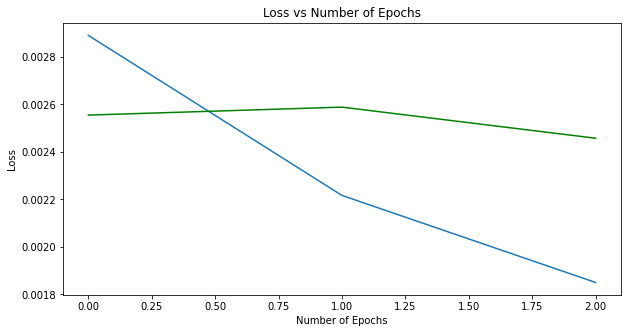

In [0]:
# Plot loss
num_epochs = np.arange(len(train_loss_set))

fig, ax = plt.subplots(figsize=(10, 5));
ax.plot(num_epochs, np.array(train_loss_set), label="Train Loss")
ax.plot(num_epochs, np.array(valid_loss_set), 'g-', label="Valid Loss")
#ax1.plot(episode_record, lose_record, 'r-', label="Lose %")
ax.set_xlabel("Number of Epochs")
ax.set_ylabel("Loss")
ax.set_title("Loss vs Number of Epochs")

## Train Model From Previous Checkpoint

In [0]:
cwd = os.getcwd()
model_save_path = output_model_file = os.path.join(cwd, "xlnet_toxic.bin")
model, start_epoch, lowest_eval_loss, train_loss_hist, valid_loss_hist = load_model(model_save_path)

In [0]:
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01, correct_bias=False)

In [0]:
num_epochs=3
model, train_loss_set, valid_loss_set = train(model=model,\
                                              num_epochs=num_epochs,\
                                              optimizer=optimizer,\
                                              train_dataloader=train_dataloader,\
                                              valid_dataloader=validation_dataloader,\
                                              model_save_path=model_save_path,\
                                              train_loss_set=train_loss_hist,\
                                              valid_loss_set=valid_loss_hist,\
                                              lowest_eval_loss=lowest_eval_loss,\
                                              start_epoch=start_epoch,\
                                              device="cuda")

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Train loss: 0.0016665047497309907


Epoch:  33%|███▎      | 1/3 [1:30:23<3:00:47, 5423.94s/it]

Valid loss: 0.0026862571389262052


Train loss: 0.0013065553756820452


Epoch:  67%|██████▋   | 2/3 [3:00:39<1:30:21, 5421.37s/it]

Valid loss: 0.002964287480941981


Train loss: 0.0010760672928326093


Epoch: 100%|██████████| 3/3 [4:30:58<00:00, 5419.65s/it]

Valid loss: 0.0033268463672464464




In [0]:
from google.colab import auth

auth.authenticate_user()

In [0]:
!gsutil cp /fakenews_datasets/XLNet_toxic_comment_classification/xlnet_toxic6.bin gs://content/xlnet_toxic.bin

AccessDeniedException: 403 avinash.ronanki@gmail.com does not have storage.objects.list access to content.


In [0]:
!gsutil cp /content/test.csv gs://fakenews_datasets/XLNet_toxic_comment_classification/test.csv

Copying file:///content/test.csv [Content-Type=text/csv]...
\
Operation completed over 1 objects/57.6 MiB.                                     


Text(0.5, 1.0, 'Loss vs Number of Epochs')

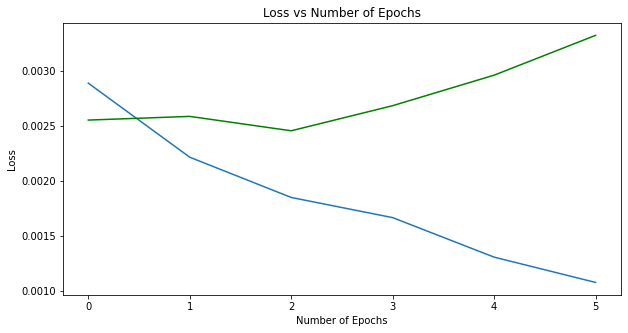

In [0]:
# Plot loss
num_epochs = np.arange(len(train_loss_set))

fig, ax = plt.subplots(figsize=(10, 5));
ax.plot(num_epochs, np.array(train_loss_set), label="Train Loss")
ax.plot(num_epochs, np.array(valid_loss_set), 'g-', label="Valid Loss")
#ax1.plot(episode_record, lose_record, 'r-', label="Lose %")
ax.set_xlabel("Number of Epochs")
ax.set_ylabel("Loss")
ax.set_title("Loss vs Number of Epochs")

## Get Predictions

In [0]:
def generate_predictions(model, df, num_labels, device="cpu", batch_size=32):
  num_iter = math.ceil(df.shape[0]/batch_size)
  
  pred_probs = np.array([]).reshape(0, num_labels)
  
  model.to(device)
  model.eval()
  
  for i in range(num_iter):
    df_subset = df.iloc[i*batch_size:(i+1)*batch_size,:]
    X = df_subset["features"].values.tolist()
    masks = df_subset["masks"].values.tolist()
    X = torch.tensor(X)
    masks = torch.tensor(masks, dtype=torch.long)
    X = X.to(device)
    masks = masks.to(device)
    with torch.no_grad():
      logits = model(input_ids=X, attention_mask=masks)
      logits = logits.sigmoid().detach().cpu().numpy()
      pred_probs = np.vstack([pred_probs, logits])
  
  return pred_probs

In [0]:
num_labels = len(label_cols)
pred_probs = generate_predictions(model, test, num_labels, device="cuda", batch_size=32)
pred_probs

NameError: ignored

In [0]:
label_cols = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

test["toxic"] = pred_probs[:,0]
test["severe_toxic"] = pred_probs[:,1]
test["obscene"] = pred_probs[:,2]
test["threat"] = pred_probs[:,3]
test["insult"] = pred_probs[:,4]
test["identity_hate"] = pred_probs[:,5]

In [0]:
test.head()

,comment_text,features,masks,toxic,severe_toxic,obscene,threat,insult,identity_hate
id,,,,,,,,,
00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,"[17, 4333, 15683, 17, 1653, 1614, 27, 70, 2718...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",9.973646e-01,6.810126e-01,9.943510e-01,2.811275e-01,9.655939e-01,6.173821e-01
0000247867823ef7,== From RfC == \n\n The title is fine as it is...,"[5847, 5383, 40, 17, 213, 722, 369, 5847, 5383...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",3.463730e-06,1.105590e-06,2.950960e-07,2.665337e-07,1.079900e-07,1.663244e-07
00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...","[17, 12, 5847, 5383, 1675, 5847, 5383, 6940, 1...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",9.510164e-06,3.645308e-07,3.329686e-07,3.394477e-07,1.168160e-07,1.529464e-07
00017563c3f7919a,":If you have a look back at the source, the in...","[17, 60, 1963, 44, 47, 24, 338, 126, 38, 18, 1...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",2.565799e-08,7.156541e-08,4.725178e-09,3.286844e-08,2.539988e-08,2.742011e-08
00017695ad8997eb,I don't anonymously edit articles at all.,"[17, 150, 220, 26, 46, 9502, 111, 8619, 2883, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",9.958533e-06,1.661719e-07,1.494095e-07,2.325547e-07,1.739687e-07,1.017955e-07


In [0]:
test_to_csv = test.reset_index()
test_to_csv.head()

,id,comment_text,features,masks,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,"[17, 4333, 15683, 17, 1653, 1614, 27, 70, 2718...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",9.973646e-01,6.810126e-01,9.943510e-01,2.811275e-01,9.655939e-01,6.173821e-01
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,"[5847, 5383, 40, 17, 213, 722, 369, 5847, 5383...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",3.463730e-06,1.105590e-06,2.950960e-07,2.665337e-07,1.079900e-07,1.663244e-07
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...","[17, 12, 5847, 5383, 1675, 5847, 5383, 6940, 1...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",9.510164e-06,3.645308e-07,3.329686e-07,3.394477e-07,1.168160e-07,1.529464e-07
3,00017563c3f7919a,":If you have a look back at the source, the in...","[17, 60, 1963, 44, 47, 24, 338, 126, 38, 18, 1...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",2.565799e-08,7.156541e-08,4.725178e-09,3.286844e-08,2.539988e-08,2.742011e-08
4,00017695ad8997eb,I don't anonymously edit articles at all.,"[17, 150, 220, 26, 46, 9502, 111, 8619, 2883, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",9.958533e-06,1.661719e-07,1.494095e-07,2.325547e-07,1.739687e-07,1.017955e-07


In [0]:
cwd = os.getcwd()
pred_save_path = output_model_file = os.path.join(cwd, "drive/My Drive/Data/toxic_1_epoch.csv")
test_to_csv[["id", "toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]].to_csv(pred_save_path, index=False)

In [0]:
np.round(pred_probs)